Saved: glv2_A2_diverse.csv, glv2_scale_matrix_S.csv

[r1] = [0.4    0.5161 1.344  0.797  1.1601]
[r2] = [0.16    0.20644 0.5376  0.3188  0.46404]

[A1]
 [[-1.8809 -0.3182  0.271  -0.1583 -0.1612]
 [ 0.0486 -2.3151  0.5961 -0.3355  0.5001]
 [ 0.0682  0.766  -1.0869 -0.1559  0.1689]
 [-1.1037  0.414   0.7708 -2.786   0.3774]
 [-0.073   0.641   0.537   0.1963 -1.8851]]

[S]
 [[1.48658775 1.22202484 1.         0.80592959 0.93876835]
 [0.77792276 1.51755897 1.75948928 0.92651594 0.88584086]
 [1.30655378 1.2471472  1.54179578 0.79475963 1.08949045]
 [1.4039706  0.68761455 0.93780122 0.76385667 0.70090007]
 [0.57772401 1.01376016 0.70634039 1.21032725 1.56974898]]

[A2]
 [[-2.79612291 -0.3888483   0.271      -0.12757865 -0.15132946]
 [ 0.03780705 -3.51330077  1.04883156 -0.3108461   0.44300901]
 [ 0.08910697  0.95531475 -1.67577783 -0.12390303  0.18401494]
 [-1.54956235  0.28467242  0.72285718 -2.12810467  0.26451969]
 [-0.04217385  0.64982027  0.37930479  0.23758724 -2.9591338 ]]


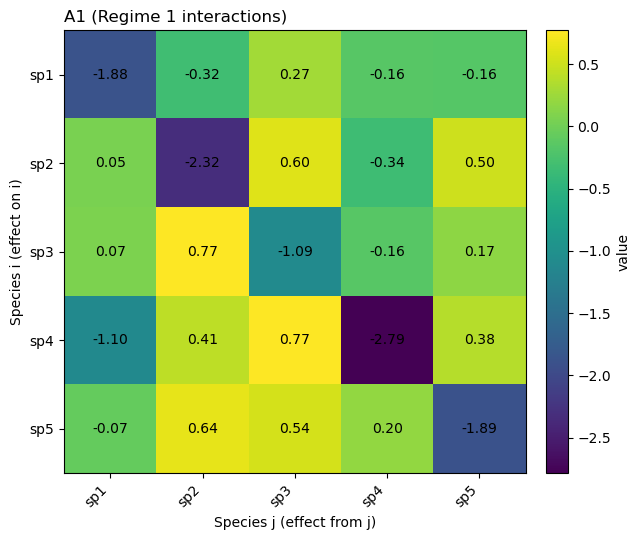

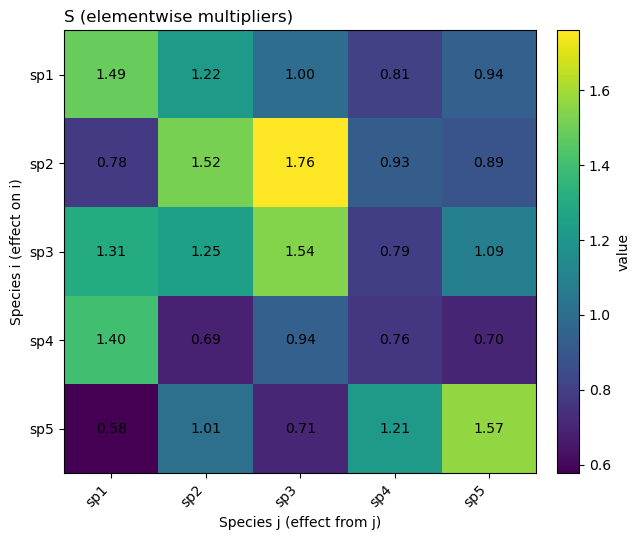

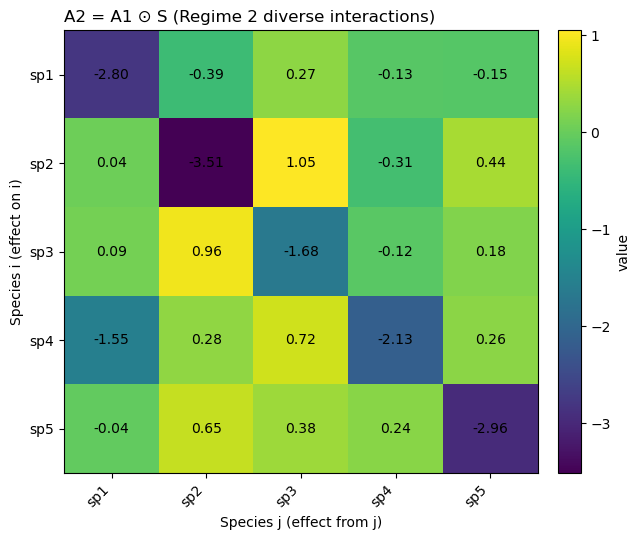

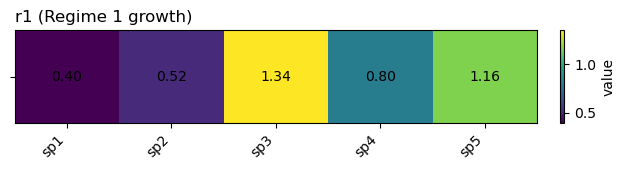

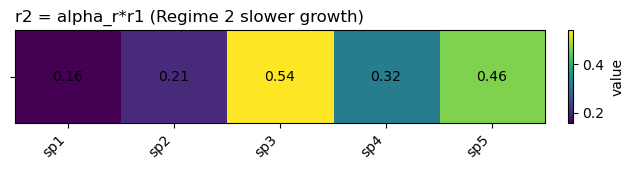

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# 0) Hyperparameters (edit here)
# ============================
species_cols = ["sp1","sp2","sp3","sp4","sp5"]

# --- gLV1 (given) ---
r1 = np.array([0.4, 0.5161, 1.344, 0.797, 1.1601], dtype=float)

A1 = np.array([
    [-1.8809, -0.3182,  0.2710, -0.1583, -0.1612],
    [ 0.0486, -2.3151,  0.5961, -0.3355,  0.5001],
    [ 0.0682,  0.7660, -1.0869, -0.1559,  0.1689],
    [-1.1037,  0.4140,  0.7708, -2.7860,  0.3774],
    [-0.0730,  0.6410,  0.5370,  0.1963, -1.8851],
], dtype=float)

# --- gLV2: still slower growth, but richer interactions ---
alpha_r = 0.4     # r2 = alpha_r * r1  (slower growth)
SEED = 7

# Interaction diversity controls
mu_scale = 1.0        # average multiplicative scale for A1
sigma_scale = 0.35    # diversity (bigger => more heterogeneous)
clip_low = 0.25       # minimum multiplier
clip_high = 2.50      # maximum multiplier

# Extra control knobs (optional but useful)
diag_multiplier = 1.35      # additional multiplier applied to diagonal (self-limitation)
offdiag_multiplier = 1.00   # additional multiplier applied to off-diagonals
preserve_zero_entries = True  # keep A1==0 entries at 0 (recommended)

# Output (optional)
OUT_A2_CSV = "glv2_A2_diverse.csv"
OUT_S_CSV  = "glv2_scale_matrix_S.csv"

# Heatmap annotation
ANNOTATE = True
ANNOT_FMT = ".2f"
FONT_SIZE = 10

# ============================
# 1) Construct r2
# ============================
r2 = alpha_r * r1

# ============================
# 2) Construct diverse A2 = A1 ⊙ S
#    Use lognormal multipliers so S > 0 (keeps sign of A1)
# ============================
rng = np.random.default_rng(SEED)
n = A1.shape[0]

# lognormal with mean around mu_scale (approx); we’ll just center by median
S = rng.lognormal(mean=0.0, sigma=sigma_scale, size=(n, n))

# rescale so median(S) ~ mu_scale
S = S * (mu_scale / np.median(S))

# clip to avoid extreme interactions
S = np.clip(S, clip_low, clip_high)

# apply separate diag/offdiag multipliers
S = S.copy()
for i in range(n):
    S[i, i] *= diag_multiplier
for i in range(n):
    for j in range(n):
        if i != j:
            S[i, j] *= offdiag_multiplier

# preserve sparsity if desired
if preserve_zero_entries:
    S = np.where(A1 == 0.0, 0.0, S)

A2 = A1 * S

# ============================
# 3) Save parameters (optional)
# ============================
pd.DataFrame(A2, index=species_cols, columns=species_cols).to_csv(OUT_A2_CSV)
pd.DataFrame(S,  index=species_cols, columns=species_cols).to_csv(OUT_S_CSV)
print(f"Saved: {OUT_A2_CSV}, {OUT_S_CSV}")

print("\n[r1] =", r1)
print("[r2] =", r2)
print("\n[A1]\n", A1)
print("\n[S]\n", S)
print("\n[A2]\n", A2)

# ============================
# 4) Plot heatmaps (A1, S, A2, r1, r2)
# ============================
def plot_heatmap_matrix(M, row_labels, col_labels, title, figsize=(6.5, 5.5),
                        annotate=True, fmt=".2f"):
    M = np.asarray(M, float)
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(M, aspect="auto")
    ax.set_title(title, loc="left")

    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_xticklabels(col_labels, rotation=45, ha="right")
    ax.set_yticklabels(row_labels)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("value", rotation=90)

    if annotate:
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                ax.text(j, i, format(M[i, j], fmt), ha="center", va="center", fontsize=FONT_SIZE)

    ax.set_xlabel("Species j (effect from j)")
    ax.set_ylabel("Species i (effect on i)")
    plt.tight_layout()
    plt.show()

def plot_heatmap_vector(v, labels, title, figsize=(6.5, 1.8),
                        annotate=True, fmt=".2f"):
    v = np.asarray(v, float).reshape(1, -1)
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(v, aspect="auto")
    ax.set_title(title, loc="left")

    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticks([0]); ax.set_yticklabels([""])

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("value", rotation=90)

    if annotate:
        for j in range(v.shape[1]):
            ax.text(j, 0, format(v[0, j], fmt), ha="center", va="center", fontsize=FONT_SIZE)

    plt.tight_layout()
    plt.show()

plot_heatmap_matrix(A1, species_cols, species_cols, "A1 (Regime 1 interactions)")
plot_heatmap_matrix(S,  species_cols, species_cols, "S (elementwise multipliers)")
plot_heatmap_matrix(A2, species_cols, species_cols, "A2 = A1 ⊙ S (Regime 2 diverse interactions)")
plot_heatmap_vector(r1, species_cols, "r1 (Regime 1 growth)")
plot_heatmap_vector(r2, species_cols, "r2 = alpha_r*r1 (Regime 2 slower growth)")

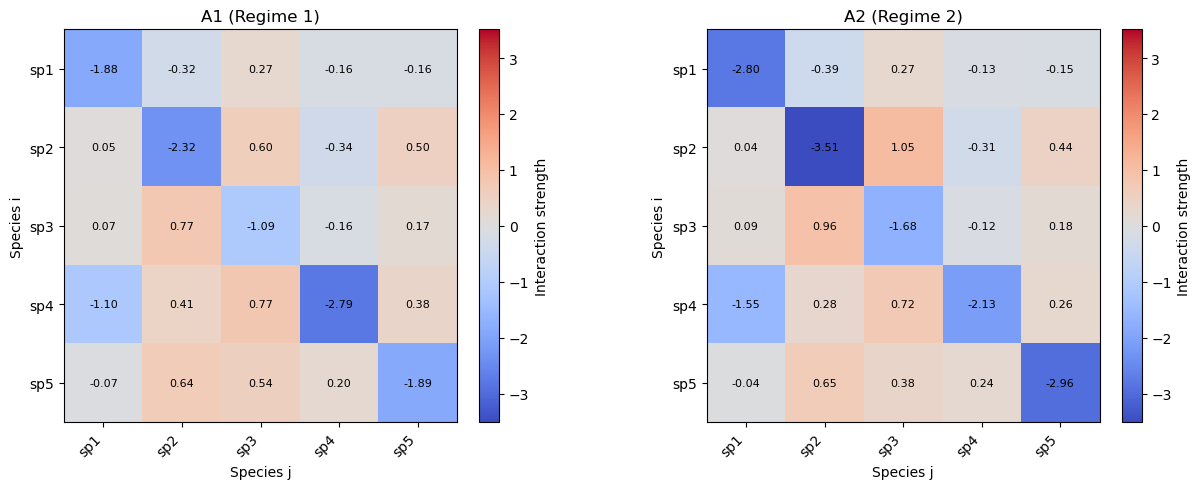

In [2]:
import numpy as np
import matplotlib.pyplot as plt

abs_max = max(abs(A1).max(), abs(A2).max())
vmin, vmax = -abs_max, abs_max

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for ax, M, title in zip(
    axes,
    [A1, A2],
    ["A1 (Regime 1)", "A2 (Regime 2)"]
):
    im = ax.imshow(M, vmin=vmin, vmax=vmax, cmap="coolwarm")

    ax.set_title(title)
    ax.set_xticks(range(len(species_cols)))
    ax.set_yticks(range(len(species_cols)))
    ax.set_xticklabels(species_cols, rotation=45, ha="right")
    ax.set_yticklabels(species_cols)
    ax.set_xlabel("Species j")
    ax.set_ylabel("Species i")

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            ax.text(
                j, i,
                f"{M[i, j]:.2f}",
                ha="center",
                va="center",
                fontsize=8,
                color="black"
            )

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Interaction strength")

plt.tight_layout()
plt.show()

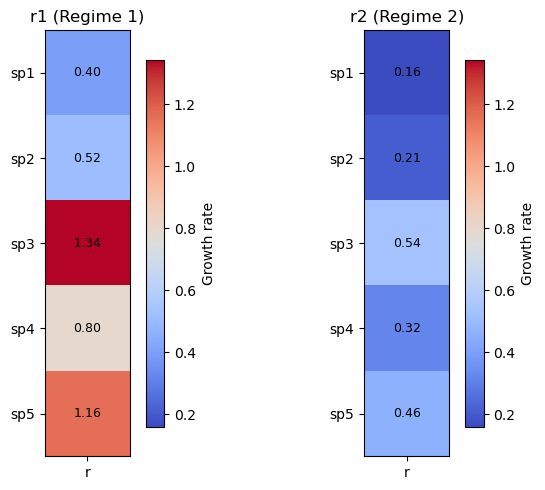

In [3]:
r_min = min(r1.min(), r2.min())
r_max = max(r1.max(), r2.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

for ax, r_vec, title in zip(
    axes,
    [r1, r2],
    ["r1 (Regime 1)", "r2 (Regime 2)"]
):
    M = r_vec.reshape(-1, 1)
    im = ax.imshow(M, vmin=r_min, vmax=r_max, cmap="coolwarm")

    ax.set_title(title)
    ax.set_yticks(range(len(species_cols)))
    ax.set_yticklabels(species_cols)
    ax.set_xticks([0])
    ax.set_xticklabels(["r"])

    for i in range(len(species_cols)):
        ax.text(0, i, f"{r_vec[i]:.2f}",
                ha="center", va="center", fontsize=9)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Growth rate")

plt.tight_layout()
plt.show()

[INFO] n=5, communities=11, time range [0.0, 20.0], target switch ~ 10.000
[INFO] Producers=['sp1', 'sp3', 'sp5'], c2=[0.9, 0.4, 1.2]
[M_init_fixed init] min_end=1.51699 -> M_init_fixed=1.44114 (safety=0.95)
[OPT] success=False, iters=11, obj=2.126
[TUNED] w_star=[1.247198, 1.783603, 0.637139, 0.539491, 0.223882], gamma_star=0.253735
[TUNED] switch times (estimate from regime1-only AM):
Comm_name  t_switch_est
   comm10      8.309989
    comm6      9.401896
    comm3     10.608262
   comm11     14.558529
    comm1           NaN
    comm2           NaN
    comm4           NaN
    comm5           NaN
    comm7           NaN
    comm8           NaN
    comm9           NaN
[M_init_fixed final] min_end_star=0.505645 -> M_init_fixed=0.455081 (safety=0.9)
[CHECK] communities with c1*AM(tf) < M_init_fixed: 0


/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_83468/2712162436.py:399: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)


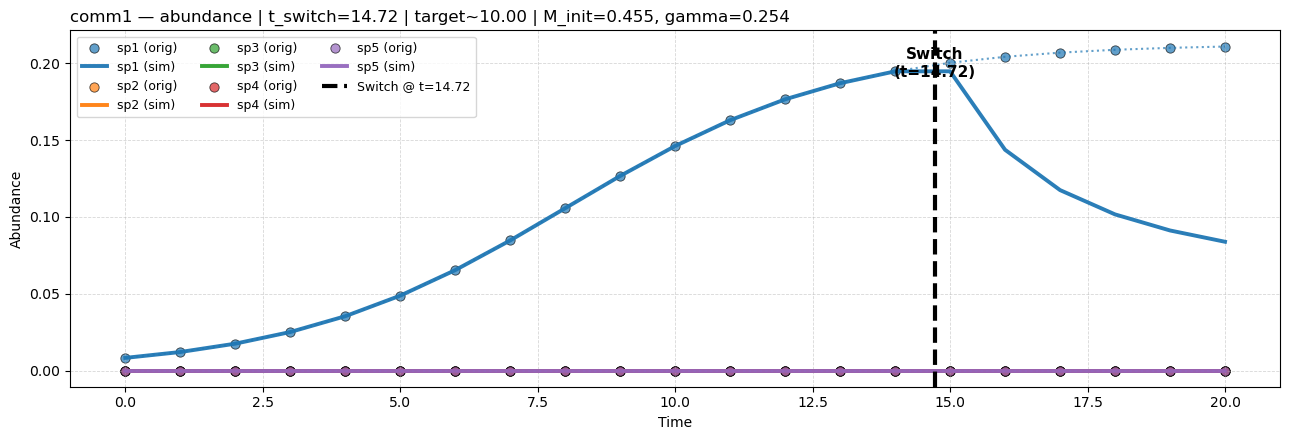

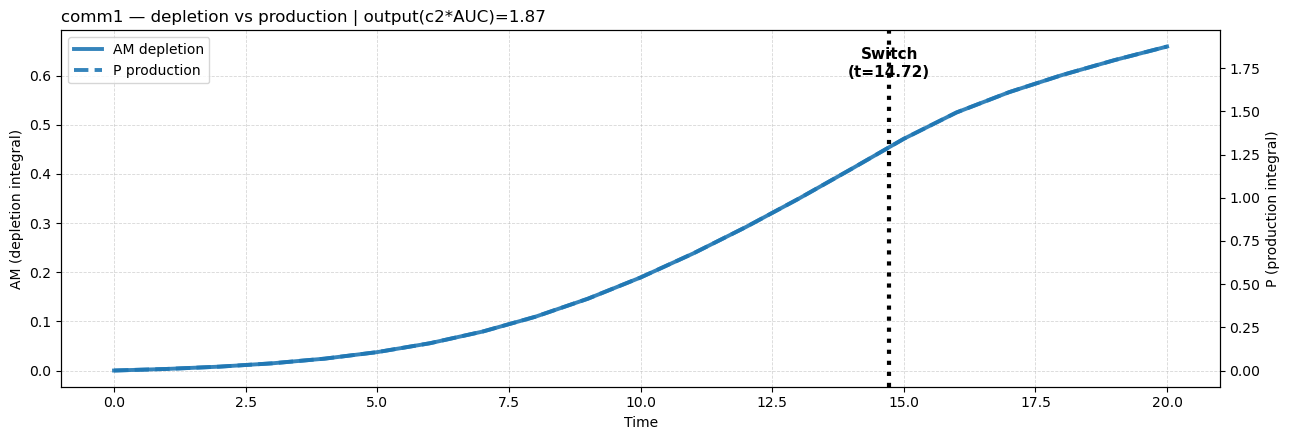

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_83468/2712162436.py:399: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)


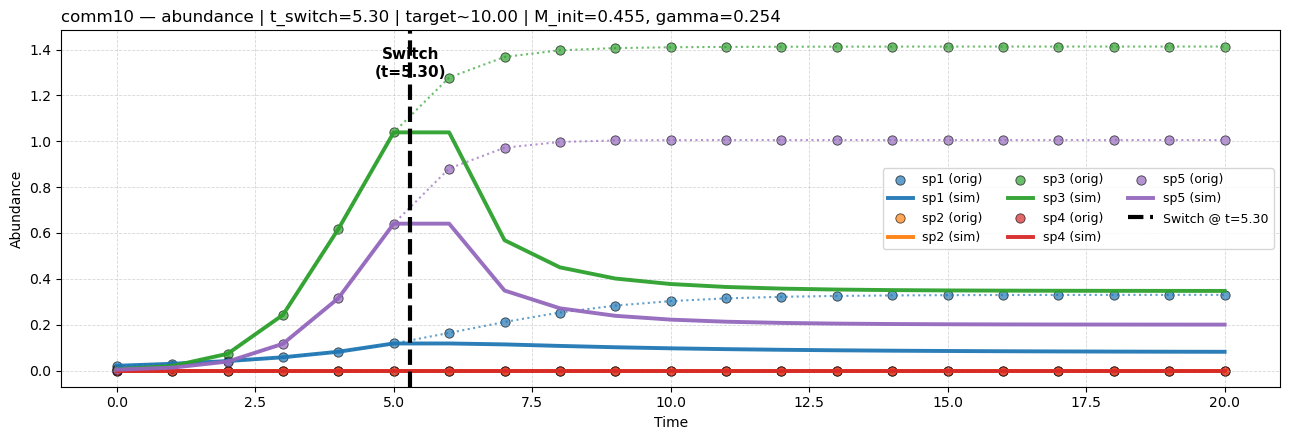

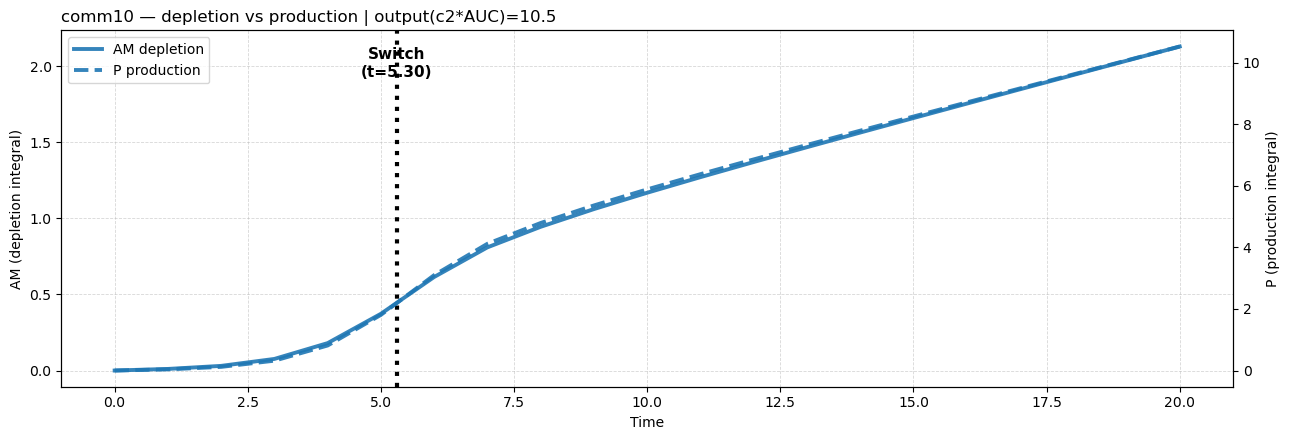

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_83468/2712162436.py:399: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)


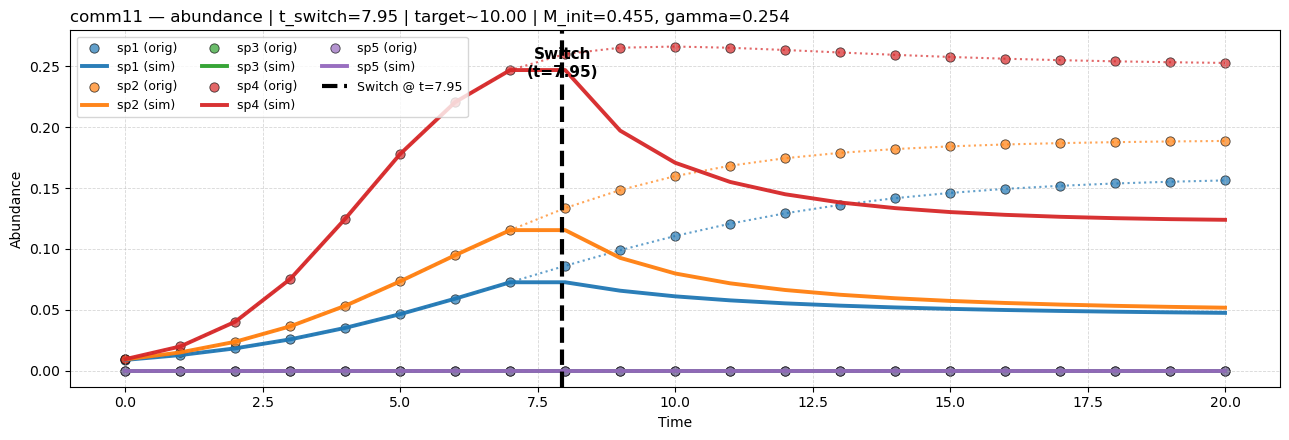

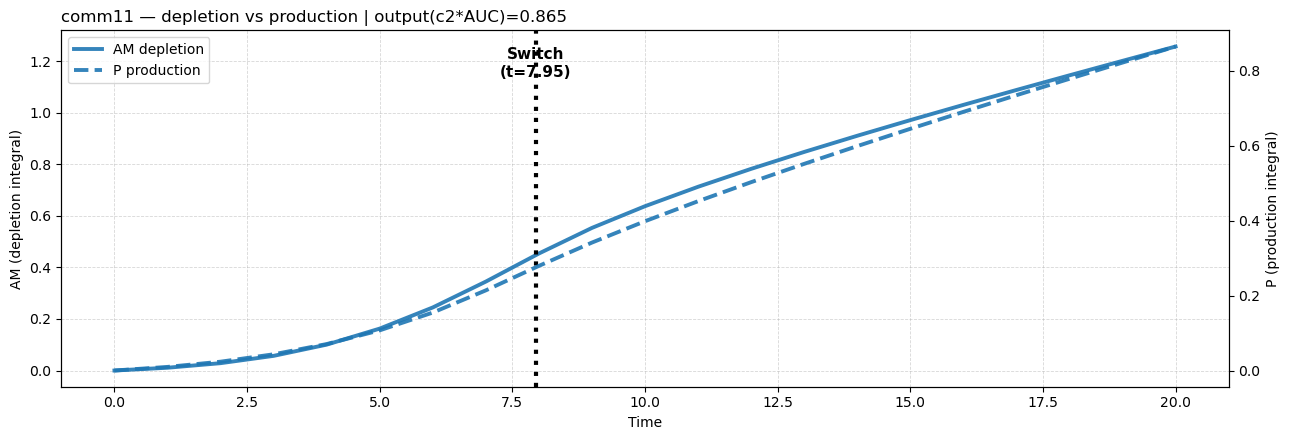

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_83468/2712162436.py:399: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)


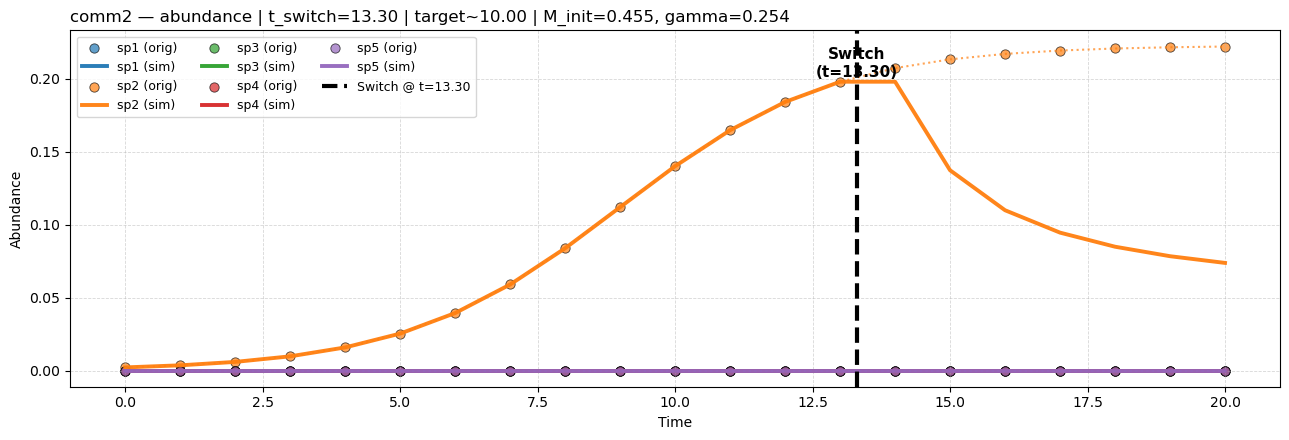

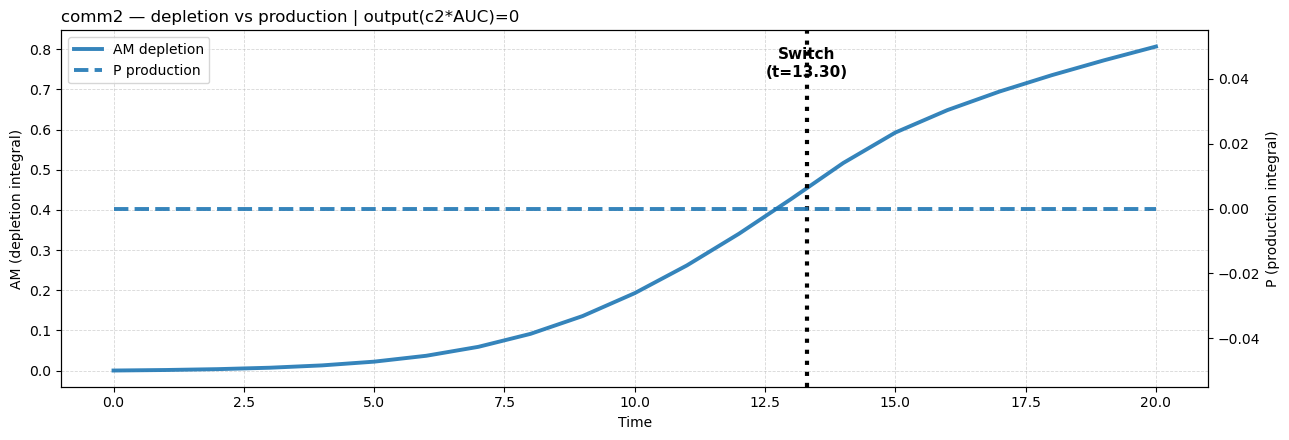

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_83468/2712162436.py:399: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)


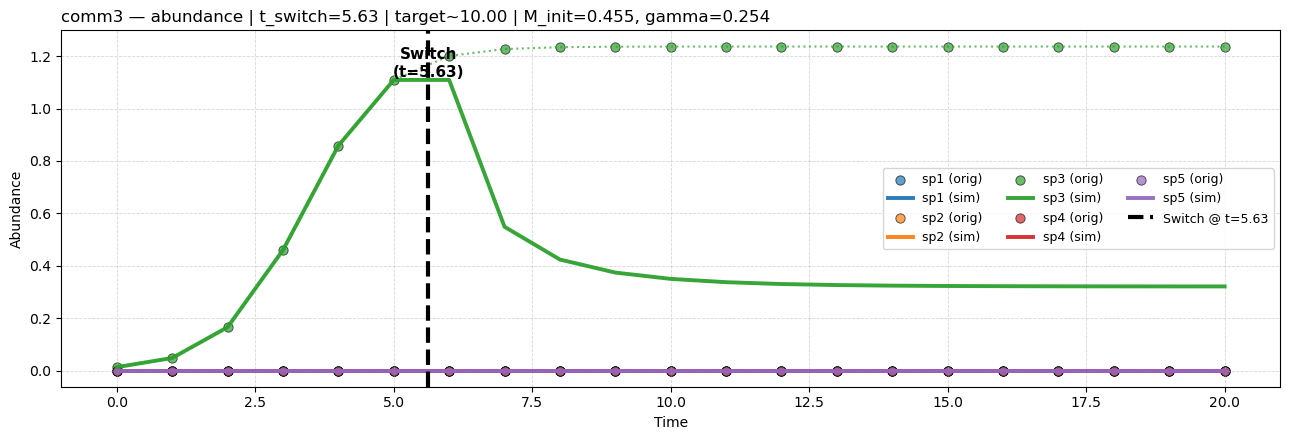

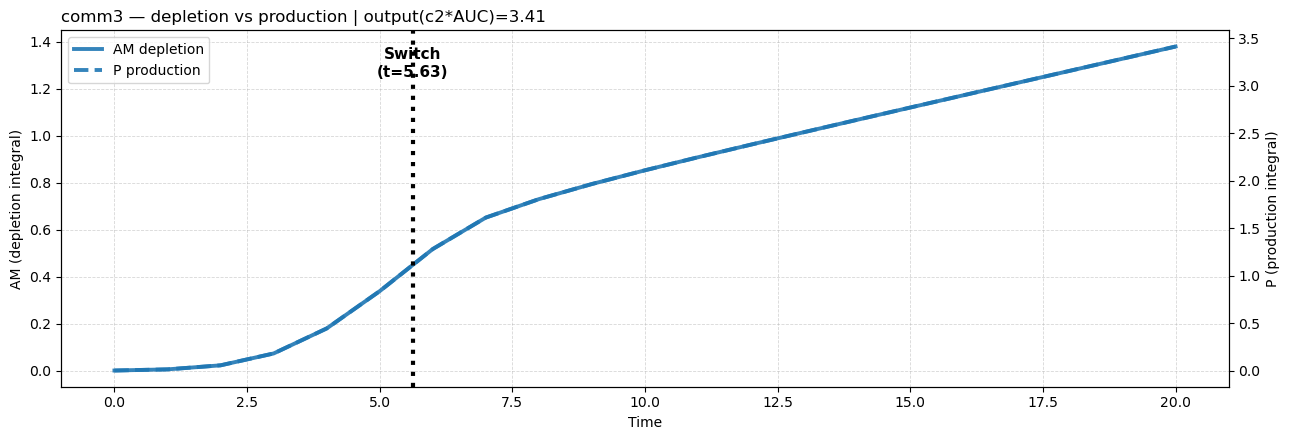

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_83468/2712162436.py:399: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)


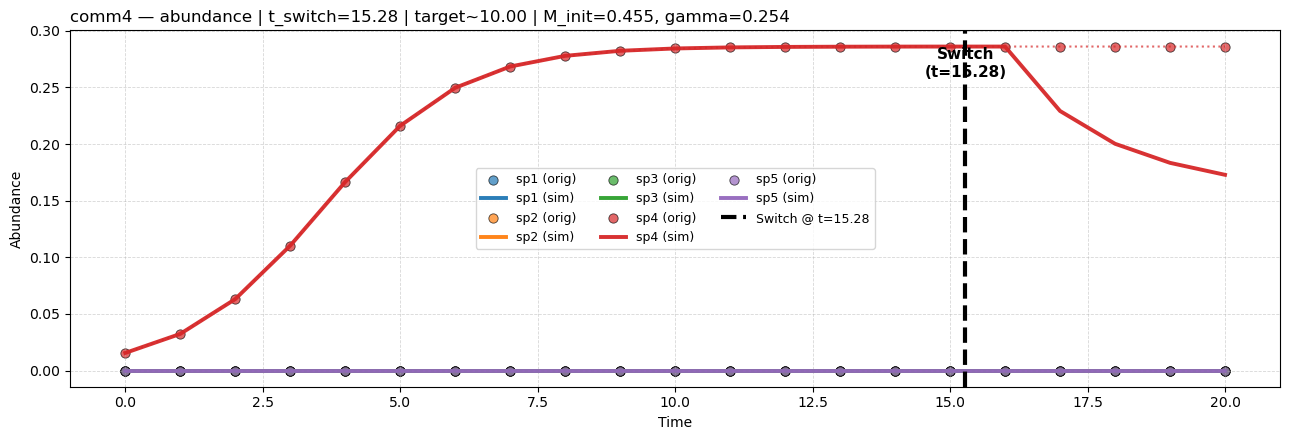

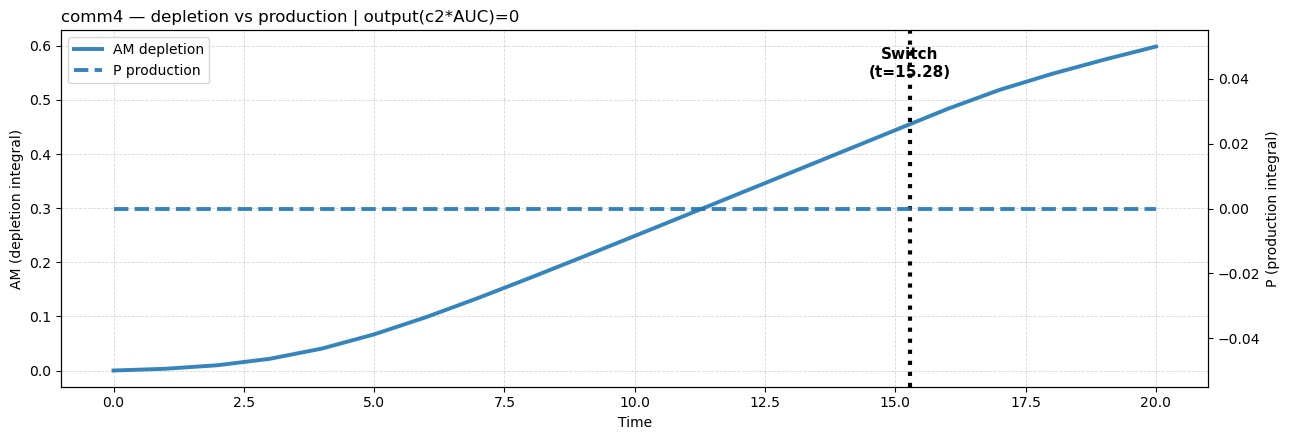

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_83468/2712162436.py:399: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)


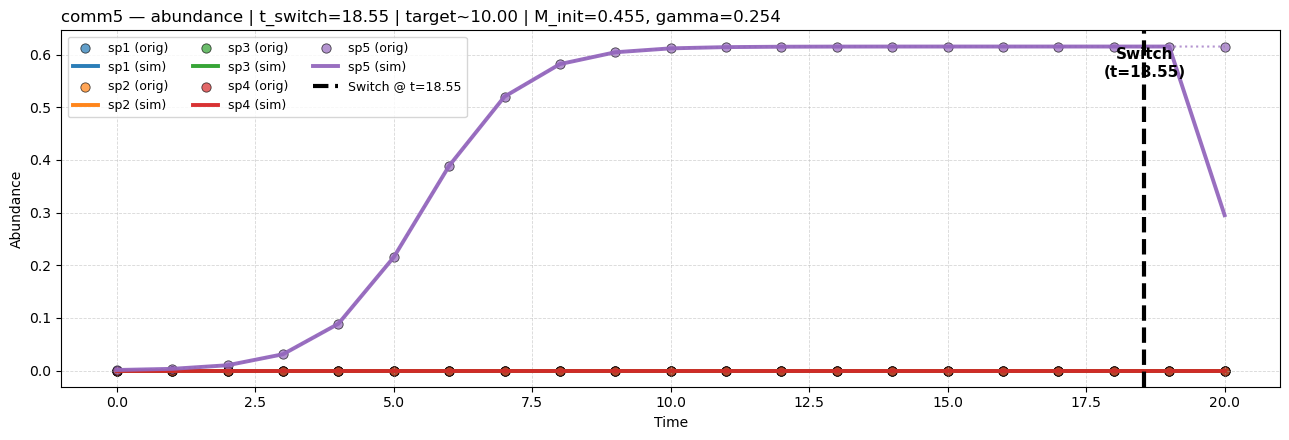

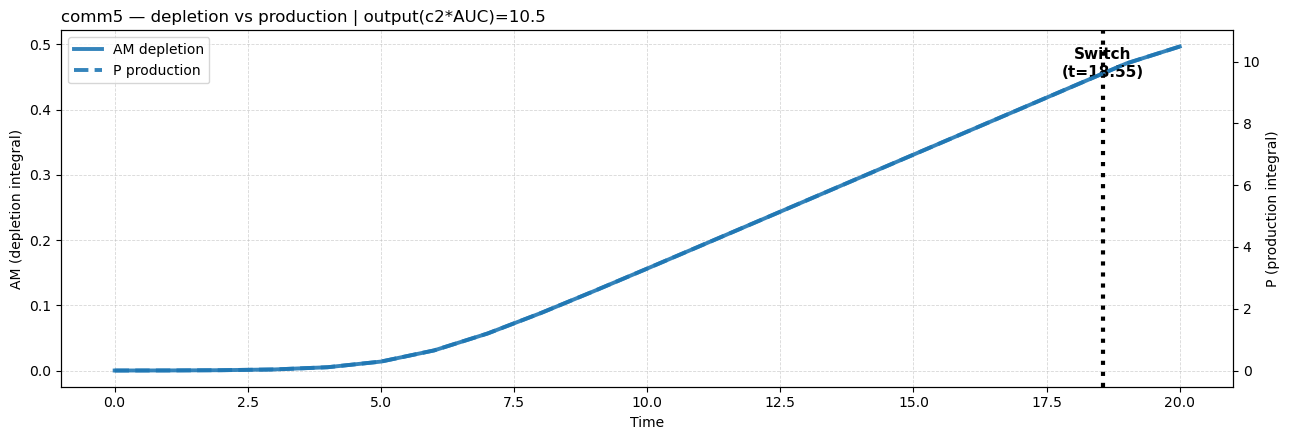

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_83468/2712162436.py:399: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)


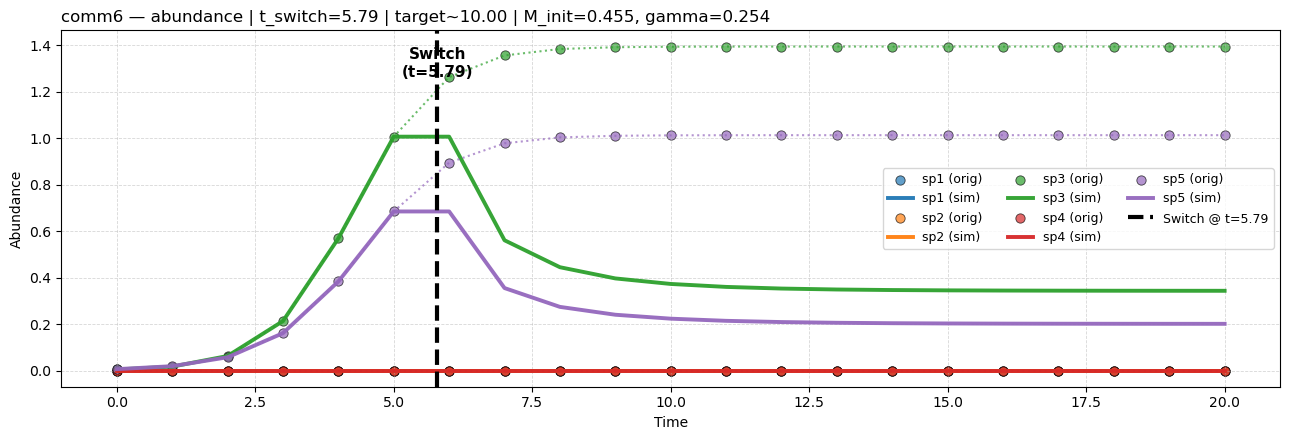

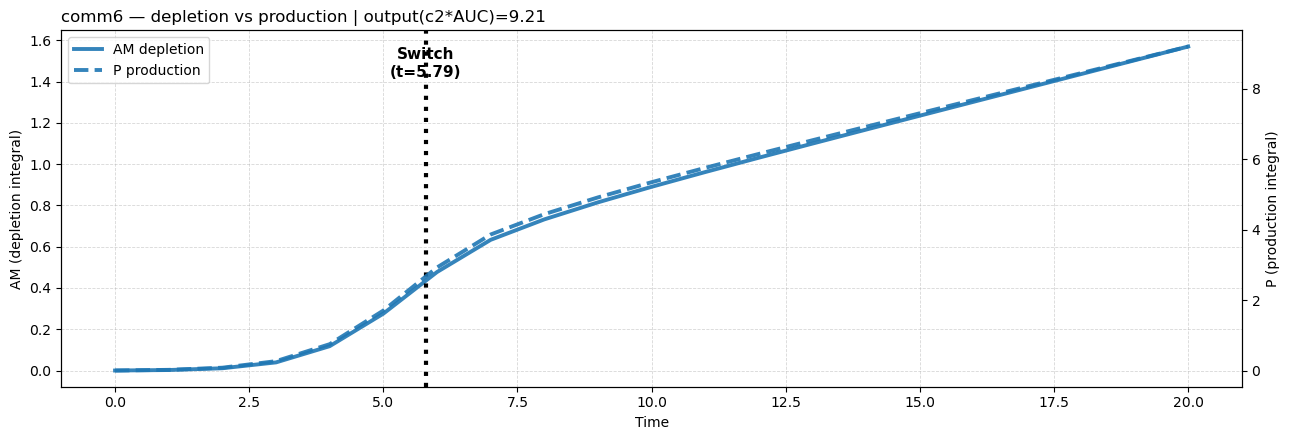

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_83468/2712162436.py:399: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)


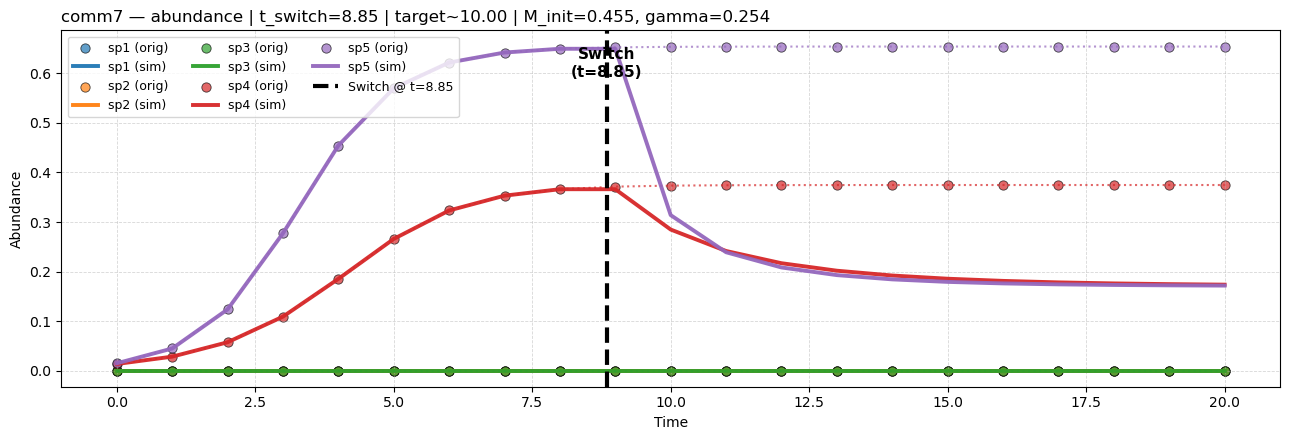

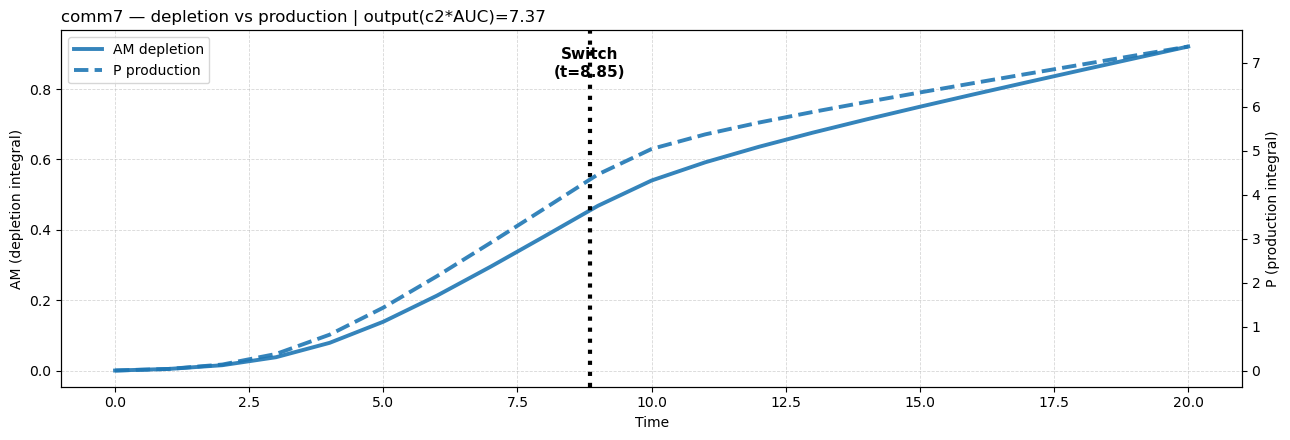

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_83468/2712162436.py:399: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)


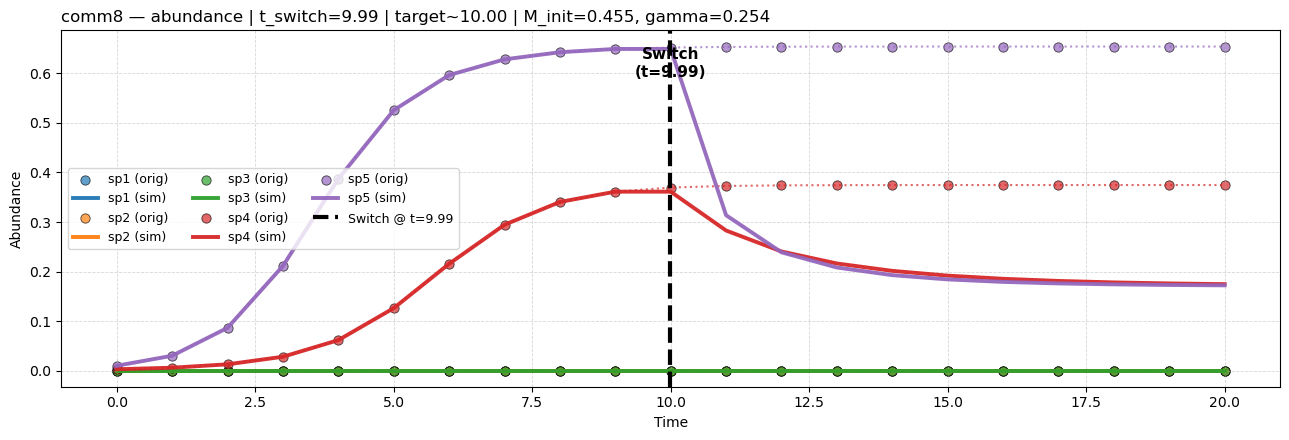

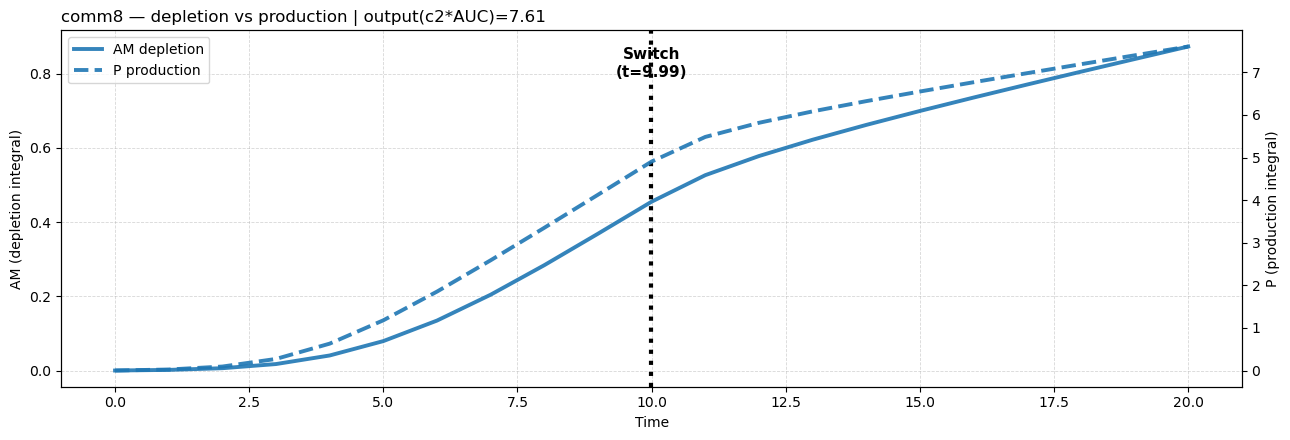

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_83468/2712162436.py:399: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)


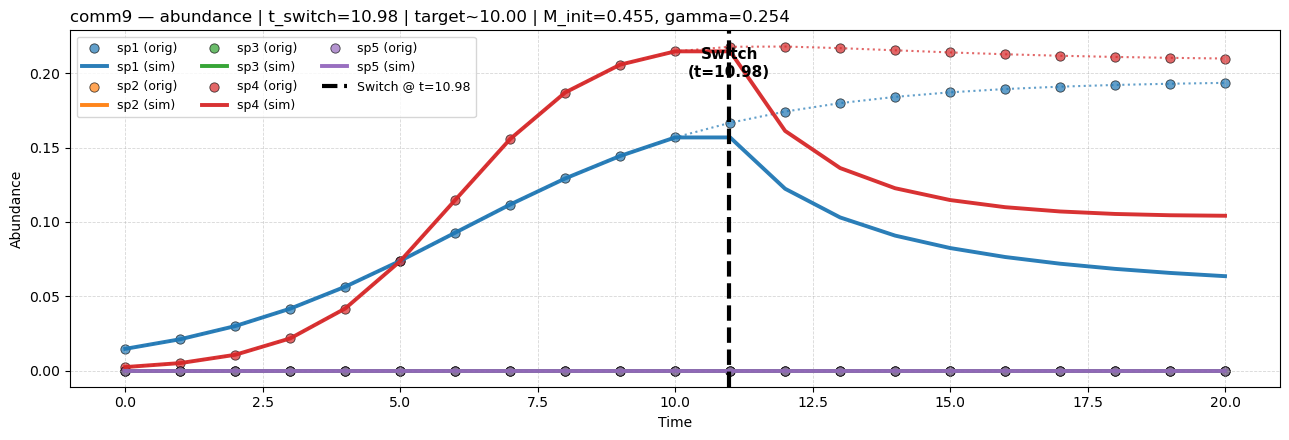

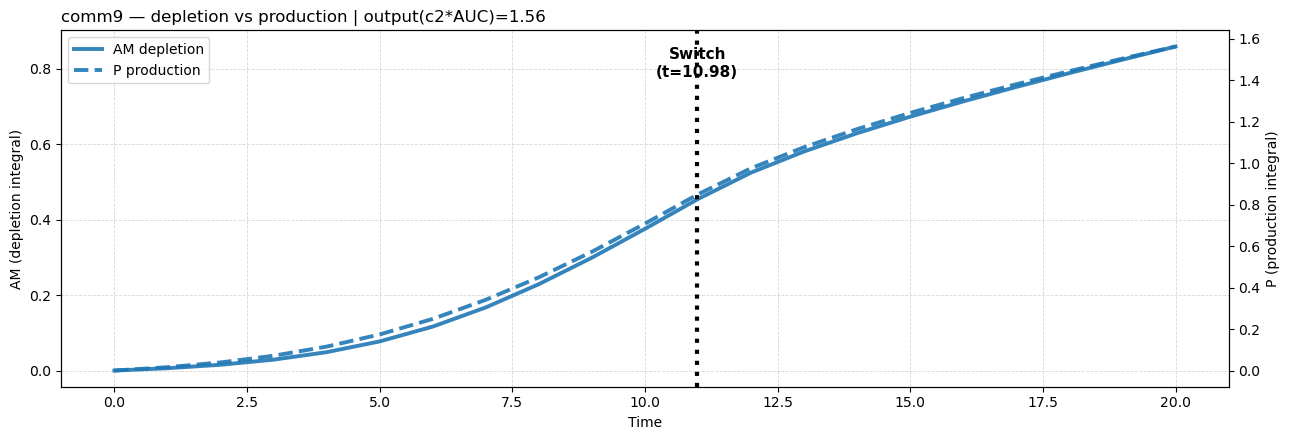


Saved simulated abundance CSV -> /Users/jiayi/Documents/Duke/26Spring/AI for biocomputing/Team project/Test/gen_data/simulated_abundance_hard_switch.csv
Saved depletion+production timeseries CSV -> /Users/jiayi/Documents/Duke/26Spring/AI for biocomputing/Team project/Test/gen_data/depletion_production_timeseries.csv
Saved production output summary CSV -> /Users/jiayi/Documents/Duke/26Spring/AI for biocomputing/Team project/Test/gen_data/production_auc_output_summary.csv

Switch times per community (final simulation):
Comm_name  t_switch
   comm10  5.299084
    comm3  5.625910
    comm6  5.786434
   comm11  7.945964
    comm7  8.845930
    comm8  9.993622
    comm9 10.983218
    comm2 13.303913
    comm1 14.723369
    comm4 15.279420
    comm5 18.553612

Final tuned depletion parameters:
w_star      = [1.247198 1.783603 0.637139 0.539491 0.223882]
gamma_star  = 0.253735
M_init_fixed= 0.455081


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# =========================================================
# 0) Hyperparameters / knobs (ALL at top)
# =========================================================
DATA_PATH = Path("test5sp_v1.csv")

OUT_SIM_ABUND    = Path("simulated_abundance_hard_switch.csv")
OUT_DEP_PROD_TS  = Path("depletion_production_timeseries.csv")
OUT_PROD_SUMMARY = Path("production_auc_output_summary.csv")

comm_col = "Comm_name"
time_col = "Time"
species_prefix = "sp"

# ---------- Regime 1 (gLV1) parameters ----------
r1 = np.array([0.4, 0.5161, 1.344, 0.797, 1.1601], dtype=float)

A1 = np.array([
    [-1.8809, -0.3182,  0.2710, -0.1583, -0.1612],
    [ 0.0486, -2.3151,  0.5961, -0.3355,  0.5001],
    [ 0.0682,  0.7660, -1.0869, -0.1559,  0.1689],
    [-1.1037,  0.4140,  0.7708, -2.7860,  0.3774],
    [-0.0730,  0.6410,  0.5370,  0.1963, -1.8851],
], dtype=float)

# ---------- Regime 2 (gLV2) parameters ----------
# IMPORTANT: Replace these with YOUR current glv2 parameters
r2 = np.array([0.16, 0.2064, 0.5376, 0.3188, 0.46404], dtype=float)

A2 = np.array([
    [-2.796123, -0.388848,  0.271000, -0.127579, -0.151329],
    [ 0.037807, -3.513301,  1.048832, -0.310846,  0.443009],
    [ 0.089107,  0.955315, -1.675778, -0.123903,  0.184015],
    [-1.549562,  0.284672,  0.722857, -2.128105,  0.264520],
    [-0.042174,  0.649820,  0.379305,  0.237587, -2.959134],
], dtype=float)

# ---------- Hard-switch trigger: c1 * AM(t) >= M_init ----------
c1 = 1.0

# We will OPTIMIZE these depletion weights (one per species):
# dAM/dt = gamma * sum_i w_i * x_i
W_INIT = np.array([0.6, 1.4, 0.8, 1.1, 0.9], dtype=float)

# Guarantee switch for all communities:
M_INIT_SAFETY_INIT  = 0.95   # used to define initial threshold before optimization
M_INIT_SAFETY_FINAL = 0.90   # if you still see NaN, decrease to 0.85 or 0.80

# We target the MIDPOINT of your timescale
TARGET_T_MODE   = "mid"  # "mid" or "manual"
TARGET_T_MANUAL = 10.0

# Optimization for w and gamma
OPT_WG = True
WG_MAXITER = 250

# Regularization knobs for objective
LAMBDA_SPREAD = 0.40
LAMBDA_W      = 0.05

# ---------- Production settings ----------
PRODUCER_SPS = ["sp1", "sp3", "sp5"]
c2 = np.array([0.9, 0.4, 1.2], dtype=float)

# ---------- Solver settings ----------
atol, rtol = 1e-8, 1e-6
METHOD = "RK45"

# ---------- Plot settings ----------
FIGSIZE = (13, 4.5)
LINEWIDTH_SIM  = 2.8
LINEWIDTH_ORIG = 1.5
MARKERSIZE = 45
ALPHA_ORIG = 0.70
ALPHA_SIM  = 0.95

# =========================================================
# 1) Load data + checks
# =========================================================
df = pd.read_csv(DATA_PATH)

species_cols = [c for c in df.columns if c.lower().startswith(species_prefix)]
species_cols = sorted(
    species_cols,
    key=lambda x: int(x[2:]) if x.lower().startswith("sp") and x[2:].isdigit() else x
)
n = len(species_cols)
if n == 0:
    raise ValueError("No species columns found (expected sp1..spN).")

r1 = np.asarray(r1, float)
A1 = np.asarray(A1, float)
r2 = np.asarray(r2, float)
A2 = np.asarray(A2, float)

if r1.shape != (n,) or A1.shape != (n, n):
    raise ValueError(f"Dimension mismatch: r1/A1 must be {(n,)} and {(n,n)}; got {r1.shape}, {A1.shape}")
if r2.shape != (n,) or A2.shape != (n, n):
    raise ValueError(f"Dimension mismatch: r2/A2 must be {(n,)} and {(n,n)}; got {r2.shape}, {A2.shape}")

if any(sp not in species_cols for sp in PRODUCER_SPS):
    raise ValueError(f"PRODUCER_SPS must be subset of {species_cols}. Got {PRODUCER_SPS}")
if len(PRODUCER_SPS) != len(c2):
    raise ValueError("c2 must have same length as PRODUCER_SPS.")

df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
for c in species_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=[comm_col, time_col] + species_cols).copy()
df = df.sort_values([comm_col, time_col]).reset_index(drop=True)

comms = df[comm_col].astype(str).unique().tolist()

# Build global time grid (unique times, sorted)
timepoints = np.sort(df[time_col].unique().astype(float))
if timepoints.size < 2:
    raise ValueError("Need at least 2 unique timepoints to simulate.")
if np.any(np.diff(timepoints) <= 0):
    raise ValueError("Global timepoints are not strictly increasing (duplicates or non-monotone).")

t0, tf = float(timepoints[0]), float(timepoints[-1])
t_mid = float(timepoints[len(timepoints)//2])
TARGET_T = t_mid if TARGET_T_MODE == "mid" else float(TARGET_T_MANUAL)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_map = {sp: colors[i % len(colors)] for i, sp in enumerate(species_cols)}

producer_idx = np.array([species_cols.index(sp) for sp in PRODUCER_SPS], dtype=int)
c2_full = np.zeros(n, dtype=float)
c2_full[producer_idx] = c2

print(f"[INFO] n={n}, communities={len(comms)}, time range [{t0}, {tf}], target switch ~ {TARGET_T:.3f}")
print(f"[INFO] Producers={PRODUCER_SPS}, c2={c2.tolist()}")

# =========================================================
# 2) Core model helpers (robust)
# =========================================================
def glv_dx(x: np.ndarray, r: np.ndarray, A: np.ndarray) -> np.ndarray:
    x = np.maximum(np.nan_to_num(x, nan=0.0), 0.0)
    return x * (r + A.dot(x))

def simulate_glv_only_on_grid(x0: np.ndarray, t_eval: np.ndarray, r: np.ndarray, A: np.ndarray):
    """
    Robust gLV simulate: always returns X shaped (len(t_eval), n).
    Handles t_eval.size == 0 or 1 gracefully.
    """
    x0 = np.maximum(np.asarray(x0, dtype=float), 0.0)
    t_eval = np.asarray(t_eval, dtype=float)
    nloc = x0.size

    if t_eval.size == 0:
        return np.zeros((0, nloc), dtype=float)
    if t_eval.size == 1:
        return x0.reshape(1, nloc).copy()
    if np.any(np.diff(t_eval) <= 0):
        raise ValueError("t_eval must be strictly increasing (no duplicates).")

    def rhs(t, x):
        x = np.asarray(x, dtype=float)
        return glv_dx(x, r, A)

    sol = solve_ivp(
        rhs,
        (float(t_eval[0]), float(t_eval[-1])),
        x0,
        t_eval=t_eval,
        method=METHOD,
        atol=atol,
        rtol=rtol,
    )
    if not sol.success:
        raise RuntimeError(sol.message)

    Y = np.asarray(sol.y, dtype=float)
    # Expect (n, T)
    if Y.ndim != 2 or Y.shape[0] != nloc or Y.shape[1] != t_eval.size:
        raise ValueError(f"Unexpected sol.y shape {Y.shape}, expected ({nloc},{t_eval.size})")

    return np.maximum(Y.T, 0.0)

def cumulative_trapz(y: np.ndarray, x: np.ndarray) -> np.ndarray:
    """Cumulative trapezoid integral with same length as x."""
    y = np.asarray(y, float)
    x = np.asarray(x, float)
    out = np.zeros_like(x, dtype=float)
    dx = np.diff(x)
    out[1:] = np.cumsum(0.5 * (y[:-1] + y[1:]) * dx)
    return out

def AM_from_X(X: np.ndarray, t_eval: np.ndarray, w: np.ndarray, gamma: float) -> np.ndarray:
    """AM(t) = gamma * ∫ sum_i w_i x_i dt on grid."""
    w = np.asarray(w, float)
    rate = X @ w
    return gamma * cumulative_trapz(rate, t_eval)

def estimate_switch_time_from_AM(t_eval: np.ndarray, AM: np.ndarray, c1: float, M_init: float):
    """First crossing time of c1*AM >= M_init (linear interpolation on grid)."""
    trig = c1 * np.asarray(AM, float)
    idx = np.where(trig >= M_init)[0]
    if idx.size == 0:
        return None
    k = int(idx[0])
    if k == 0:
        return float(t_eval[0])
    tL, tR = float(t_eval[k-1]), float(t_eval[k])
    yL, yR = float(trig[k-1]), float(trig[k])
    if yR <= yL:
        return float(tR)
    frac = (M_init - yL) / (yR - yL)
    return float(tL + frac * (tR - tL))

def simulate_piecewise_with_AM_P(
    x0: np.ndarray, t_eval: np.ndarray,
    r1: np.ndarray, A1: np.ndarray,
    r2: np.ndarray, A2: np.ndarray,
    w: np.ndarray, gamma: float,
    c2_full: np.ndarray,
    c1: float, M_init: float
):
    """
    Piecewise hard switch:
      1) simulate Regime1 on full grid -> compute AM -> t_switch
      2) simulate Regime1 on tp1, Regime2 on tp2, stitch
      3) compute AM and P on stitched X
    Returns X, t_switch, AM, P
    """
    t_eval = np.asarray(t_eval, float)
    x0 = np.maximum(np.asarray(x0, float), 0.0)

    # 1) find t_switch from regime1-only full trajectory
    X1_full = simulate_glv_only_on_grid(x0, t_eval, r1, A1)
    AM1_full = AM_from_X(X1_full, t_eval, w=w, gamma=gamma)
    t_switch = estimate_switch_time_from_AM(t_eval, AM1_full, c1=c1, M_init=M_init)

    if t_switch is None:
        # no switch
        P = cumulative_trapz(X1_full @ c2_full, t_eval)
        return X1_full, None, AM1_full, P

    # 2) split grid
    tp1 = t_eval[t_eval <= t_switch]
    tp2 = t_eval[t_eval >  t_switch]

    X1 = simulate_glv_only_on_grid(x0, tp1, r1, A1) if tp1.size > 0 else np.zeros((0, n))
    x_switch = X1[-1].copy() if X1.shape[0] > 0 else x0.copy()
    X2 = simulate_glv_only_on_grid(x_switch, tp2, r2, A2) if tp2.size > 0 else np.zeros((0, n))

    # 3) stitch (ensure second dim is n even for empty)
    if X1.ndim != 2 or X1.shape[1] != n:
        raise ValueError(f"X1 has wrong shape {X1.shape}")
    if X2.ndim != 2 or X2.shape[1] != n:
        raise ValueError(f"X2 has wrong shape {X2.shape}")

    X = np.vstack([X1, X2])

    # compute AM and P on full grid
    AM = AM_from_X(X, t_eval, w=w, gamma=gamma)
    P  = cumulative_trapz(X @ c2_full, t_eval)
    return X, float(t_switch), AM, P

# =========================================================
# 3) Precompute Regime1-only X(t) for each community (speed)
# =========================================================
X1_cache = {}
x0_cache = {}
for comm in comms:
    sub = df[df[comm_col].astype(str) == comm].sort_values(time_col)
    x0 = np.maximum(sub.iloc[0][species_cols].to_numpy(float), 0.0)
    x0_cache[comm] = x0
    X1_cache[comm] = simulate_glv_only_on_grid(x0, timepoints, r1, A1)

# =========================================================
# 4) Initial M_init (safe) based on W_INIT and gamma=1
# =========================================================
def compute_min_end_c1AM(w: np.ndarray, gamma: float):
    ends = []
    for comm in comms:
        AM = AM_from_X(X1_cache[comm], timepoints, w=w, gamma=gamma)
        ends.append(c1 * float(AM[-1]))
    ends = np.asarray(ends, float)
    return float(np.min(ends)), ends

min_end_init, end_vals_init = compute_min_end_c1AM(W_INIT, gamma=1.0)
M_init_fixed = float(M_INIT_SAFETY_INIT * min_end_init)
print(f"[M_init_fixed init] min_end={min_end_init:.6g} -> M_init_fixed={M_init_fixed:.6g} (safety={M_INIT_SAFETY_INIT})")

# =========================================================
# 5) Optimize w and gamma so t_switch ~ TARGET_T
# =========================================================
def switch_times_given_w_gamma(w: np.ndarray, gamma: float):
    ts = []
    for comm in comms:
        AM = AM_from_X(X1_cache[comm], timepoints, w=w, gamma=gamma)
        t_sw = estimate_switch_time_from_AM(timepoints, AM, c1=c1, M_init=M_init_fixed)
        ts.append(np.nan if t_sw is None else float(t_sw))
    return np.asarray(ts, float)

def objective_logw_loggamma(z: np.ndarray):
    logw = z[:n]
    logg = z[n]
    w = np.exp(logw)
    gamma = float(np.exp(logg))

    ts = switch_times_given_w_gamma(w, gamma)
    ts = ts[np.isfinite(ts)]
    if ts.size == 0:
        return 1e6

    med_abs_dev = float(np.median(np.abs(ts - TARGET_T)))
    spread = float(np.std(ts))
    reg_w = float(np.mean(logw**2))
    return med_abs_dev + LAMBDA_SPREAD * spread + LAMBDA_W * reg_w

if OPT_WG:
    z0 = np.concatenate([np.log(np.maximum(W_INIT, 1e-12)), [0.0]])  # gamma init = 1
    res = minimize(
        objective_logw_loggamma, z0,
        method="L-BFGS-B",
        options={"maxiter": WG_MAXITER}
    )
    z_star = res.x
    w_star = np.exp(z_star[:n])
    gamma_star = float(np.exp(z_star[n]))
    print(f"[OPT] success={res.success}, iters={res.nit}, obj={res.fun:.4g}")
else:
    w_star = W_INIT.copy()
    gamma_star = 1.0

ts_star = switch_times_given_w_gamma(w_star, gamma_star)
print(f"[TUNED] w_star={np.round(w_star, 6).tolist()}, gamma_star={gamma_star:.6g}")
print("[TUNED] switch times (estimate from regime1-only AM):")
print(pd.DataFrame({"Comm_name": comms, "t_switch_est": ts_star}).sort_values("t_switch_est").to_string(index=False))

# =========================================================
# 5b) Recompute M_init_fixed with tuned (w,gamma) to GUARANTEE switching
# =========================================================
end_vals_star = []
for comm in comms:
    AM = AM_from_X(X1_cache[comm], timepoints, w=w_star, gamma=gamma_star)
    end_vals_star.append(c1 * float(AM[-1]))
end_vals_star = np.asarray(end_vals_star, float)

min_end_star = float(np.min(end_vals_star))
M_init_fixed = float(M_INIT_SAFETY_FINAL * min_end_star)
print(f"[M_init_fixed final] min_end_star={min_end_star:.6g} -> M_init_fixed={M_init_fixed:.6g} (safety={M_INIT_SAFETY_FINAL})")

bad = np.where(end_vals_star < M_init_fixed)[0]
print(f"[CHECK] communities with c1*AM(tf) < M_init_fixed: {bad.size}")
if bad.size > 0:
    for idx in bad:
        print("  ", comms[idx], end_vals_star[idx])

# =========================================================
# 6) Run hard-switch simulation, plot, and save CSVs
# =========================================================
sim_rows = []
dep_prod_rows = []
summary_rows = []
switch_rows = []

for comm in comms:
    sub = df[df[comm_col].astype(str) == comm].sort_values(time_col)
    t_obs = sub[time_col].to_numpy(float)
    X_obs = sub[species_cols].to_numpy(float)
    x0 = x0_cache[comm].copy()

    X_sim, t_switch, AM_sim, P_sim = simulate_piecewise_with_AM_P(
        x0=x0, t_eval=timepoints,
        r1=r1, A1=A1,
        r2=r2, A2=A2,
        w=w_star, gamma=gamma_star,
        c2_full=c2_full,
        c1=c1, M_init=M_init_fixed
    )

    switch_rows.append((comm, t_switch))

    # Save time series rows
    for ti, t in enumerate(timepoints):
        sim_row = {comm_col: comm, time_col: float(t)}
        for j, sp in enumerate(species_cols):
            sim_row[sp] = float(X_sim[ti, j])
        sim_rows.append(sim_row)

        dep_prod_rows.append({
            comm_col: comm,
            time_col: float(t),
            "AM_depletion": float(AM_sim[ti]),
            "P_production": float(P_sim[ti]),
        })

    # output = sum_i c2_i * AUC_i
    auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)
    output_total = float(np.sum(c2_full * auc_per_sp))

    producer_break = {f"AUC_{sp}": float(auc_per_sp[species_cols.index(sp)]) for sp in PRODUCER_SPS}
    producer_c2auc = {f"c2AUC_{sp}": float(c2_full[species_cols.index(sp)] * auc_per_sp[species_cols.index(sp)])
                      for sp in PRODUCER_SPS}

    summary = {
        comm_col: comm,
        "t_switch": (float(t_switch) if t_switch is not None else np.nan),
        "output_total_c2_auc": output_total,
    }
    summary.update(producer_break)
    summary.update(producer_c2auc)
    summary_rows.append(summary)

    # ============================
    # Plot 1: abundance (orig vs sim)
    # ============================
    fig, ax = plt.subplots(figsize=FIGSIZE)

    for j, sp in enumerate(species_cols):
        col = color_map[sp]
        ax.plot(t_obs, X_obs[:, j], linestyle=":", linewidth=LINEWIDTH_ORIG, color=col, alpha=ALPHA_ORIG)
        ax.scatter(t_obs, X_obs[:, j], s=MARKERSIZE, color=col, edgecolor="black",
                   linewidth=0.6, alpha=ALPHA_ORIG, label=f"{sp} (orig)")
        ax.plot(timepoints, X_sim[:, j], linestyle="-", linewidth=LINEWIDTH_SIM,
                color=col, alpha=ALPHA_SIM, label=f"{sp} (sim)")

    if t_switch is not None:
        ax.axvline(t_switch, linestyle="--", linewidth=3.0, color="black",
                   label=f"Switch @ t={t_switch:.2f}")
        ax.text(t_switch, ax.get_ylim()[1] * 0.95, f"Switch\n(t={t_switch:.2f})",
                ha="center", va="top", fontsize=11, fontweight="bold", color="black")
        sw_txt = f"{t_switch:.2f}"
    else:
        sw_txt = "None"

    ax.set_title(
        f"{comm} — abundance | t_switch={sw_txt} | target~{TARGET_T:.2f} | "
        f"M_init={M_init_fixed:.3g}, gamma={gamma_star:.3g}",
        loc="left"
    )
    ax.set_xlabel("Time")
    ax.set_ylabel("Abundance")
    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)

    handles, labels = ax.get_legend_handles_labels()
    seen = set()
    new_h, new_l = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            new_h.append(h); new_l.append(l); seen.add(l)
    ax.legend(new_h, new_l, ncol=3, fontsize=9)

    plt.tight_layout()
    plt.show()

    # ============================
    # Plot 2: depletion vs production
    # ============================
    fig2, ax1 = plt.subplots(figsize=FIGSIZE)
    ax2 = ax1.twinx()

    ax1.plot(timepoints, AM_sim, linewidth=2.8, linestyle="-", alpha=0.9, label="AM depletion")
    ax1.set_ylabel("AM (depletion integral)")
    ax2.plot(timepoints, P_sim, linewidth=2.8, linestyle="--", alpha=0.9, label="P production")
    ax2.set_ylabel("P (production integral)")

    if t_switch is not None:
        ax1.axvline(t_switch, linestyle=":", linewidth=3.0, color="black")
        ax1.text(t_switch, ax1.get_ylim()[1] * 0.95, f"Switch\n(t={t_switch:.2f})",
                 ha="center", va="top", fontsize=11, fontweight="bold", color="black")

    ax1.set_title(
        f"{comm} — depletion vs production | output(c2*AUC)={output_total:.3g}",
        loc="left"
    )
    ax1.set_xlabel("Time")
    ax1.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left", fontsize=10)

    plt.tight_layout()
    plt.show()

# =========================================================
# 7) Save CSV outputs
# =========================================================
df_sim = pd.DataFrame(sim_rows)
df_sim.to_csv(OUT_SIM_ABUND, index=False)

df_dep_prod = pd.DataFrame(dep_prod_rows)
df_dep_prod.to_csv(OUT_DEP_PROD_TS, index=False)

df_summary = pd.DataFrame(summary_rows)
df_summary.to_csv(OUT_PROD_SUMMARY, index=False)

print(f"\nSaved simulated abundance CSV -> {OUT_SIM_ABUND.resolve()}")
print(f"Saved depletion+production timeseries CSV -> {OUT_DEP_PROD_TS.resolve()}")
print(f"Saved production output summary CSV -> {OUT_PROD_SUMMARY.resolve()}")

sw_df = pd.DataFrame(switch_rows, columns=["Comm_name", "t_switch"])
print("\nSwitch times per community (final simulation):")
print(sw_df.sort_values("t_switch").to_string(index=False))

print("\nFinal tuned depletion parameters:")
print(f"w_star      = {np.round(w_star, 6)}")
print(f"gamma_star  = {gamma_star:.6g}")
print(f"M_init_fixed= {M_init_fixed:.6g}")

[INFO] Total communities: 11
[INFO] Valid t_switch: 11
[INFO] NaN / missing t_switch: 0


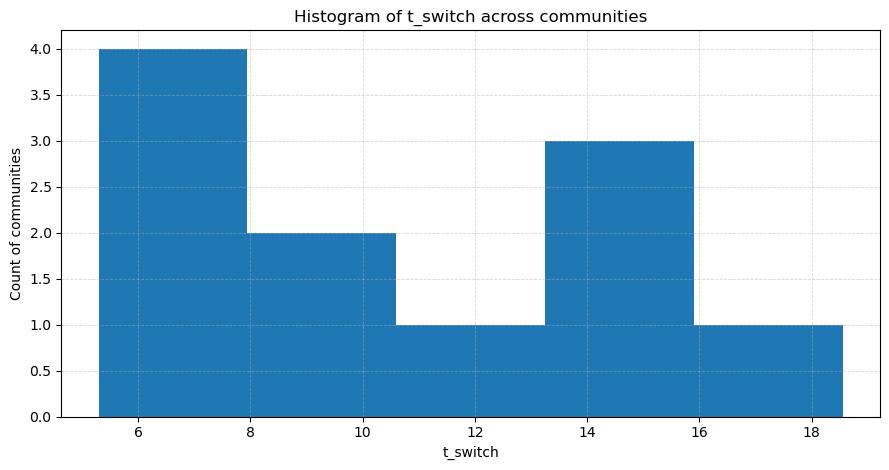

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Path to your summary output
# ----------------------------
SUMMARY_PATH = Path("production_auc_output_summary.csv")  # or your actual path
comm_col = "Comm_name"
ts_col = "t_switch"

# ----------------------------
# Load + clean
# ----------------------------
df = pd.read_csv(SUMMARY_PATH)

if comm_col not in df.columns or ts_col not in df.columns:
    raise ValueError(f"CSV must contain columns: {comm_col}, {ts_col}. Got: {df.columns.tolist()}")

df[ts_col] = pd.to_numeric(df[ts_col], errors="coerce")

ts_all = df[ts_col].to_numpy(float)
ts = ts_all[np.isfinite(ts_all)]

print(f"[INFO] Total communities: {len(df)}")
print(f"[INFO] Valid t_switch: {ts.size}")
print(f"[INFO] NaN / missing t_switch: {(~np.isfinite(ts_all)).sum()}")

# ----------------------------
# Plot histogram
# ----------------------------
plt.figure(figsize=(9, 4.8))
plt.hist(ts, bins="auto")  # you can also set bins=20, 30, etc.
plt.xlabel("t_switch")
plt.ylabel("Count of communities")
plt.title("Histogram of t_switch across communities")
plt.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
plt.tight_layout()
plt.show()